In [29]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/raman/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [143]:
from os import listdir
from nltk.corpus import stopwords
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline


In [92]:
#Load a single document
def load_doc(filename):
    #open file in read mode
    file = open(filename, 'r')
    #read text
    text = file.read()
    #close file
    file.close()
    return text

In [93]:
#Clean the document : Returns tokens
def clean_doc(doc):
    tokens = doc.split()
    table = str.maketrans('','',punctuation)
    tokens = [w.translate(table) for w in tokens]
    #remove tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    #filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    #filter out short tokens
    tokens = [word for word in tokens if len(word)>1]
    return tokens

In [94]:
def add_doc_to_vocab(filename,vocab):
    doc = load_doc(filename)
    tokens = clean_doc(doc)
    vocab.update(tokens)

In [95]:
def process_docs(directory, vocab):
    for filename in listdir(directory):
        if not filename.endswith('.txt'):
            continue
        path = directory+'/'+filename
        add_doc_to_vocab(path, vocab)

In [96]:
vocab = Counter()
process_docs('txt_sentoken/neg', vocab)
process_docs('txt_sentoken/pos', vocab)

In [97]:
#Drop tokens with low occurence
min_occurance = 5
tokens = [k for k,c in vocab.items() if c>=min_occurance]


In [98]:
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [99]:
save_list(tokens,'vocab.txt')

In [100]:
vocab_filename = 'vocab.txt'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [101]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [102]:
#Load the reviews to pandas
def get_line(directory,vocab,target):
    lines = []
    churn = []
    #walk through all files in folder
    for filename in listdir(directory):
        #skip files that do not have right extension
        if not filename.endswith(".txt"):
            continue
        #Create path to file to open
        path = directory+'/'+filename
        #load and clean the doc
        line = doc_to_line(path,vocab)
        lines.append(line)
        churn.append(target)
    return lines,churn

In [103]:
negative_lines,negative_churn = get_line('txt_sentoken/neg', vocab, 0)

In [104]:
positive_lines, positive_churn = get_line('txt_sentoken/pos', vocab, 1)

In [105]:
import pandas as pd

In [106]:
df = pd.DataFrame({"text": negative_lines+positive_lines,"target":negative_churn+positive_churn})

In [107]:
df.head()

,target,text
0,0,senseless marlon wayans talented physical come...
1,0,last summer featurelength version avengers hit...
2,0,synopsis mentally unstable man saves boy poten...
3,0,film features richard lynch role chief villain...
4,0,inner flag last year nick pulled dragnet rerun...


In [108]:
df.shape

(2000, 2)

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=2000,min_df=5,max_df=0.7,stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(negative_lines+positive_lines).toarray()

In [117]:
y = negative_churn+positive_churn

In [110]:
from sklearn.model_selection import train_test_split

In [120]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

array([[0.        , 0.04331571, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.0432542 , 0.        , ..., 0.        , 0.0526548 ,
        0.        ],
       ...,
       [0.05707585, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04796114, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [63]:
from sklearn.ensemble import RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=100,random_state=0)
text_classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [64]:
predictions = text_classifier.predict(X_test)

In [65]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

In [66]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

[[174  26]
 [ 48 152]]
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       200
           1       0.85      0.76      0.80       200

   micro avg       0.81      0.81      0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400

0.815


In [73]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [74]:
y_pred = svclassifier.predict(X_test)

In [75]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))

[[165  35]
 [ 29 171]]
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       200
           1       0.83      0.85      0.84       200

   micro avg       0.84      0.84      0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400

0.84


In [153]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation,Dropout
from keras.preprocessing.text import Tokenizer,one_hot
from keras.layers import GlobalMaxPooling1D
from keras.layers import Conv1D,LSTM

In [128]:
X = negative_lines+positive_lines
Y = np.array(negative_churn+positive_churn)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [131]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [134]:
#Adding one because of reserved zero index
vocab_size = len(tokenizer.word_index)+1
max_len = 100

X_train = pad_sequences(X_train,padding='post', maxlen=max_len)
X_test = pad_sequences(X_test,padding='post',maxlen=max_len)

In [135]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [136]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding='utf-8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [137]:
embedding_matrix = zeros((vocab_size,100))
for word,index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [138]:
#Creating the neural networks
model = Sequential()
embedding_layer = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

In [139]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1475600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10001     
Total params: 1,485,601
Trainable params: 10,001
Non-trainable params: 1,475,600
_________________________________________________________________
None


In [141]:
history = model.fit(X_train,y_train,batch_size=128,epochs=20,verbose=1,validation_split=0.2)

Train on 1280 samples, validate on 320 samples
Epoch 1/20
1280/1280 [==============================] - 0s 79us/step - loss: 0.2014 - acc: 0.9898 - val_loss: 0.6465 - val_acc: 0.6438
Epoch 2/20
1280/1280 [==============================] - 0s 40us/step - loss: 0.1786 - acc: 0.9953 - val_loss: 0.6897 - val_acc: 0.6281
Epoch 3/20
1280/1280 [==============================] - 0s 42us/step - loss: 0.1580 - acc: 0.9953 - val_loss: 0.6646 - val_acc: 0.6375
Epoch 4/20
1280/1280 [==============================] - 0s 33us/step - loss: 0.1380 - acc: 1.0000 - val_loss: 0.6438 - val_acc: 0.6625
Epoch 5/20
1280/1280 [==============================] - 0s 39us/step - loss: 0.1212 - acc: 1.0000 - val_loss: 0.6529 - val_acc: 0.6594
Epoch 6/20
1280/1280 [==============================] - 0s 35us/step - loss: 0.1094 - acc: 1.0000 - val_loss: 0.6681 - val_acc: 0.6500
Epoch 7/20
1280/1280 [==============================] - 0s 53us/step - loss: 0.0994 - acc: 1.0000 - val_loss: 0.6581 - val_acc: 0.6594
Epoch 8/

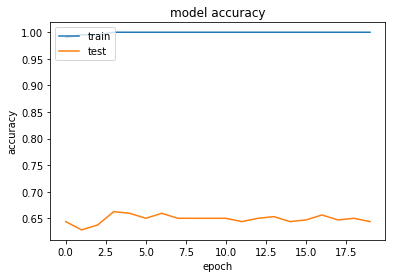

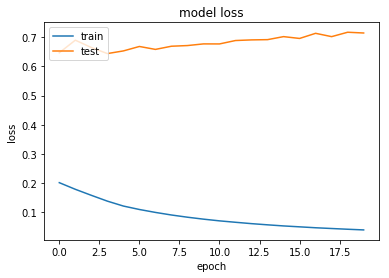

In [145]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [148]:
model = Sequential()

embedding_layer = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len,trainable=False)
model.add(embedding_layer)
model.add(Conv1D(128,5,activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])

In [149]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1475600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,539,857
Trainable params: 64,257
Non-trainable params: 1,475,600
_________________________________________________________________
None


In [150]:
history = model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)
score = model.evaluate(X_test,y_test,verbose=1)

Train on 1280 samples, validate on 320 samples
Epoch 1/6
1280/1280 [==============================] - 2s 2ms/step - loss: 0.7103 - acc: 0.5281 - val_loss: 0.6510 - val_acc: 0.6250
Epoch 2/6
1280/1280 [==============================] - 1s 1ms/step - loss: 0.5741 - acc: 0.7523 - val_loss: 0.6241 - val_acc: 0.6813
Epoch 3/6
1280/1280 [==============================] - 1s 1ms/step - loss: 0.5062 - acc: 0.8211 - val_loss: 0.6108 - val_acc: 0.6719
Epoch 4/6
1280/1280 [==============================] - 1s 1ms/step - loss: 0.4418 - acc: 0.9055 - val_loss: 0.5992 - val_acc: 0.6937
Epoch 5/6
1280/1280 [==============================] - 1s 1ms/step - loss: 0.3923 - acc: 0.9477 - val_loss: 0.5973 - val_acc: 0.6844
Epoch 6/6
400/400 [==============================] - 0s 423us/step


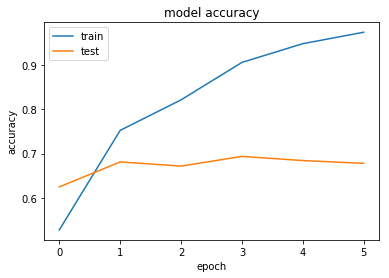

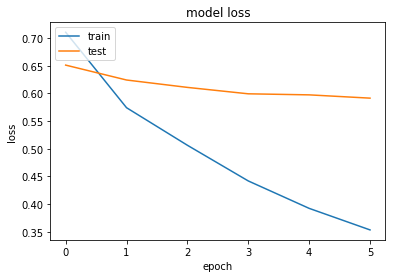

In [151]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()


In [154]:
#Building a RNN
model = Sequential()
embedding_layer = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len,trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['acc'])

In [155]:
model.fit(X_train,y_train,batch_size=16,epochs=10)
score = model.evaluate(X_test,y_test,batch_size=16)

Epoch 1/10
1600/1600 [==============================] - 18s 11ms/step - loss: 0.6484 - acc: 0.6125
Epoch 2/10
1600/1600 [==============================] - 17s 11ms/step - loss: 0.6061 - acc: 0.6850
Epoch 3/10
1600/1600 [==============================] - 18s 11ms/step - loss: 0.5836 - acc: 0.7163
Epoch 4/10
1600/1600 [==============================] - 18s 11ms/step - loss: 0.5222 - acc: 0.7450
Epoch 5/10
1600/1600 [==============================] - 19s 12ms/step - loss: 0.4921 - acc: 0.7588
Epoch 6/10
1600/1600 [==============================] - 18s 12ms/step - loss: 0.4879 - acc: 0.7719
Epoch 7/10
1600/1600 [==============================] - 18s 11ms/step - loss: 0.4298 - acc: 0.8031
Epoch 8/10
1600/1600 [==============================] - 18s 11ms/step - loss: 0.3867 - acc: 0.8263
Epoch 9/10
1600/1600 [==============================] - 18s 11ms/step - loss: 0.3593 - acc: 0.8444
Epoch 10/10
400/400 [==============================] - 1s 2ms/step
